<a href="https://colab.research.google.com/github/IsaacFigNewton/DAG-Based-Compression/blob/main/DAG_Text_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO


0.  Understand connected_components(adjacency_matrix, directed=True, return_labels=True) more in-depth
1.  Convert each token embedding in the intermediate process to a sparse matrix
2.  Refactor the suffix tree composition algorithm to take a divide-and-conquer aka a split-and-merge approach using multithreading
3.  Represent vectorization of text as fourth dimension, with token vector scaling corresponding to token frequencies or paths

# Install packages and import libraries

In [44]:
import time
import re
from threading import Thread

import math
import random
from queue import Queue
import numpy as np
import urllib.request as url
import pandas as pd
import json

from scipy.sparse.csgraph import connected_components
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')

#Important functions

##Utility

###Operational

In [2]:
def tokenize(text, token_dict, max_token_len):
    # filter to include only tokens shorter than the
    available_tokens = {token: freq for token, freq in token_dict.items() if len(token) <= max_token_len}

    # sort tokens by length and secondarily frequency
    best_tokens = sorted(list(available_tokens.items()),
                         key=lambda x: (-len(x[0]), -x[1]))

    # extract tokens from the ordered list
    tokenization = []
    while text != "":
        for token, freq in best_tokens:
            if text.startswith(token):
                tokenization.append(token)
                text = text[len(token):]

    return tokenization

In [80]:
def calculate_distances_for_subgraph(labels, distance_matrix, adjacency_matrix, subgraph_id):
    """
    Calculate Manhattan distances for nodes in a specific subgraph and update the distance matrix.

    Parameters:
    labels (numpy array): Array of subgraph labels for each node.
    distance_matrix (numpy array): 3D array to store the distances.
    adjacency_matrix (numpy array): Adjacency matrix of the graph.
    subgraph_id (int): ID of the subgraph to process.
    """
    subgraph_vertices = np.where(labels == subgraph_id)[0]
    n = adjacency_matrix.shape[0]

    # Prepare meshgrid for distance calculation (may need optimization for large n)
    x_coords, y_coords = np.arange(n), np.arange(n)
    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')

    for i in subgraph_vertices:
        # Calculate Manhattan distance and apply inverse distance
        distances = 1 / np.maximum(np.abs(X - i) + np.abs(Y - i), 1)

        # Mask to consider only edges within the subgraph
        mask = (adjacency_matrix != 0) & ((X == i) | (Y == i) | np.isin(X, subgraph_vertices) | np.isin(Y, subgraph_vertices))

        # Update distance matrix
        distance_matrix[i, :, :] = np.where(mask, distances, distance_matrix[i, :, :])

In [86]:
def vectorize_adjacency_matrix(adjacency_matrix, low_mem=True):
    """
    Vectorize the adjacency matrix by calculating Manhattan distances for each subgraph.

    Parameters:
    adjacency_matrix (numpy array): Adjacency matrix of the graph.

    Returns:
    numpy array: 3D distance matrix.
    """
    n = adjacency_matrix.shape[0]
    distance_matrix = np.zeros((n, n, n), dtype=float)

    # Identify subgraphs and their labels
    num_subgraphs, labels = connected_components(adjacency_matrix, directed=True, return_labels=True)

    if low_mem:
        # Calculate distances for each subgraph in series
        for subgraph_id in range(num_subgraphs):
            calculate_distances_for_subgraph(labels, distance_matrix, adjacency_matrix, subgraph_id)
    else:
        # Calculate distances for each subgraph in parallel
        # Create and start threads for each subgraph
        threads = []
        for subgraph_id in range(num_subgraphs):
            thread = Thread(target=calculate_distances_for_subgraph,
                            args=(labels,
                                  distance_matrix,
                                  adjacency_matrix,
                                  subgraph_id))
            thread.start()
            threads.append(thread)

        # Wait for all threads to complete
        for thread in threads:
            thread.join()

    return distance_matrix

### Plotting and Printing

In [5]:
def print_tree(tree, indent = 0):
    # Iterate over the child.suffixes (features) in the tree
    for child in tree.children:
        print(' ' * indent + str(child.suffix) + ": " + str(child.frequency))
        # If the child is a SuffixNode, recursively print the subtree
        if isinstance(child, SuffixNode):
            print_tree(child, indent + 4)
        else:
            print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))

In [6]:
def plot_embeddings(embeddings, max_plots):
  i = 0
  for token, vector in embeddings.items():
    if (i < max_plots):
        print("Embedding for'" + token + "':")

        # Create the heatmap
        sns.heatmap(vector, annot=False, cmap='viridis')

        # Display the heatmap
        plt.show()
        i += 1

In [7]:
def plot_dag(dag_store, A=None, edge_set=None, scaling=50, edge_width=1, k=2):

    if A is None:
        # Initialize a directed graph
        G = nx.DiGraph()
        # Add edges to the graph
        for parent, child, position in edge_set:
            G.add_edge(parent, child)#, weight=position)

    else:
        # Create a directed graph from the adjacency matrix
        G = nx.from_numpy_array(A, create_using=nx.DiGraph)

        # Relabel the token nodes
        G = nx.relabel_nodes(G, dag_store.reversed_token_map)

        # # Draw the graph without edge labels
        # # Convert nodes to strings before calculating length
        # nx.draw(G, with_labels=True, node_size=[scaling * len(str(node)) for node in G.nodes()],
        #         width=edge_width, font_size=8)


    # Calculate figure size based on the number of nodes
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    graph_size = (num_nodes) + (2 * num_edges)

    figsize = graph_size * scaling/300
    font_size = 2 + math.sqrt(scaling)/5

    # Position nodes using the spring layout
    pos = nx.spring_layout(G, seed=42, k=k/num_nodes)

    # Calculate node sizes based on the length of the token text
    node_sizes = [scaling * len(node) for node in G.nodes()]

    plt.figure(figsize=(figsize, figsize), dpi=300)

    # Draw nodes with sizes proportional to the length of their text
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Draw edges with widths based on edge weights
    nx.draw_networkx_edges(G,
                          pos,
                          edgelist=edge_set,
                          width=edge_width,
                          arrowstyle='-|>',
                          connectionstyle="arc3,rad=0.2")

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif")

    # # Draw edge weight labels
    # edge_labels = nx.get_edge_attributes(G, "weight")
    # nx.draw_networkx_edge_labels(G, pos, edge_labels)

    # Customize and show plot
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()

    plt.show()

## Classes

### SuffixNode Class
Let:
*    n=text length
*    b=mean block size
*    l=mean inter-block lexical diversity (l = n/b if every block has a unique suffix tree and l < n/b if some blocks have shared suffix tree compositions)

<br>

Blocked Ukkonen time complexity: O(n)
*   If split with preprocessing (O(n) time), parallelization in a divide-and-conquer approach would offer maximum time complexity of O(b*l)



pruning time complexity: O(log(b*l))

tokenization time complexity: O(log(b*l))

In [8]:
class SuffixNode:
    def __init__(self,
                 suffix=None,
                 token=None,
                 frequency=0,
                 parent=None,
                 children=None):
        self.suffix = suffix
        self.token = token
        self.frequency = frequency

        self.parent = parent

        if children is None:
            children = set()  # Initialize children as an empty set
        self.children = children

    def __str__(self):
        return self.suffix


    def split_edge(self, child, i):
      old_suffix = child.suffix[i:]
      new_suffix = self.suffix[i:]

      # Replace the old entry for the current node with a new one for the edge split
      split_node = SuffixNode(suffix=child.suffix[:i],
                              frequency=child.frequency,
                              parent=self,
                              children=child.children)

      # Remove the old child and add the new split node
      self.children.remove(child)
      self.children.add(split_node)

      # Create a new node for the existing edge suffix
      new_child = SuffixNode(suffix=old_suffix,
                              frequency=1,
                              parent=split_node,
                              children=split_node.children)

      # Transfer the children to the new split node's child
      for grandchild in split_node.children:
          grandchild.parent = new_child

      # Create a new node for the new suffix
      #     and move both it and the previous suffix beneath the split node
      split_node.children = {new_child,
                              SuffixNode(suffix=new_suffix,
                                        frequency=1,
                                        parent=split_node)
      }


    def add_suffix(self, suffix):

        # Find the longest prefix match in the children
        for child in self.children:

            # Find the index of the longest common prefix
            i = 0
            while i < len(child.suffix) and i < len(suffix) and child.suffix[i] == suffix[i]:
                i += 1

            # If there is a common prefix
            if i > 0:
                # Update the frequency of the current node
                child.frequency += 1

                # If the common prefix is the entire child key, recurse into that child
                if i == len(child.suffix):
                    child.add_suffix(suffix[i:])

                # If the common prefix is only part of the child key, split the edge
                elif i < len(suffix):
                    self.split_edge(child, i)

                return

        # No matching prefix, add the suffix as a new child
        self.children.add(SuffixNode(suffix=suffix,
                                     frequency=1,
                                     parent=self))


    def build_tree(self, text, do_blocking=True, delimeters=r"\n"):
        clauses = [text]
        # split the text into blocks, where each block is an independent clause
        if (do_blocking):
          clauses = re.split(delimeters, text)

        for string in clauses:
            # loop through the string, starting with the last character
            for i in range(0, len(string)):
                suffix = string[len(string) - i - 1:]

                # add the suffix to the tree
                self.add_suffix(suffix)


    def prune_tree(self, threshold=2):
        # If the node has no children (ie it's a leaf), return
        if not self.children:
            # print("no children")
            return

        children_to_kill = set()
        # Recursively prune the tree
        for child in self.children:

            if isinstance(child, SuffixNode):
                # if the child is above the threshold or it's a single character token node
                if child.frequency >= threshold or child.parent is None:
                    # print("not removed")
                    child.prune_tree(threshold)
                else:
                    # print("removed")
                    children_to_kill.add(child)

        for child in children_to_kill:
            # if the token's frequency falls below the threshold, prune it
            self.children.remove(child)


    # set all the suffix tree nodes' token properties
    # return an aggregated set of all the tokens
    def get_tokens(self, prev_token=""):
        tokens = dict()

        for child in self.children:
            if isinstance(child, SuffixNode):
                token = prev_token + child.suffix

                # set the child's token for later use
                child.token = token

                # add the accumulation of the current suffix with previous suffixes
                #   as a new token in the token set, with the previously found frequency
                tokens[token] = child.frequency
                # Recursively get tokens from the child
                tokens.update(child.get_tokens(token))

        return tokens

In [9]:
def build_suffix_tree(text,
                      threshold,
                      do_blocking=True,
                      delimeters=r"\n",
                      tree=None):
  # use the tree option in case a previous tree is to be pruned further
  suffix_tree = tree
  if suffix_tree is None:
    suffix_tree = SuffixNode(children = { SuffixNode(suffix=unique_char) for unique_char in set(text) })
    suffix_tree.build_tree(text,
                          do_blocking=do_blocking,
                          delimeters=delimeters)
  suffix_tree.prune_tree(threshold=threshold)

  tokens = suffix_tree.get_tokens()
  alphabet = list(set(text))

  return suffix_tree, tokens, { alphabet[i]: i for i in range(len(alphabet)) }

### CompositionDAGNode
construction time complexity: O(log(|V| + |E|))

In [10]:
class DAGStore:
  def __init__(self,
               vertices=None,
               edge_set=None,
               token_index_map=None,
               adjacency_matrix=None):

      if vertices is None:
        vertices = dict()
      if edge_set is None:
        edge_set = set()

      self.vertices = vertices
      self.edge_set = edge_set
      self.token_index_map = token_index_map
      self.reversed_token_map = None
      # first dimension = outgoing token node
      # second dimension = incoming token node
      self.adjacency_matrix = adjacency_matrix

In [11]:
class CompositionDAGNode:
    def __init__(self,
                 token=None,
                 frequency=0,
                 parents=None,
                 children=None,
                 dag_store=None):
        self.token = token
        self.frequency = frequency

        if parents is None:
            parents = list()
        self.parents = parents

        if children is None:
            children = set()
        self.children = children

        if dag_store is None:
            dag_store = DAGStore()
        self.dag_store = dag_store

    def __str__(self):
        child_tokens = {child.token for child in self.children}
        parent_tokens = {parent.token for parent in self.parents}
        return f"Token: {self.token}\nParents: {parent_tokens}\nChildren: {child_tokens}"

    # make an edge between the current token and a successor
    def add_edge(self, child):
        # Add the larger token as a child of this token
        self.children.add(child)

        # Add this token to the list of parents composing the larger token
        child.parents.append(self)

        # Add an edge to the edge list, using the current token's position
        #   in the child token as the edge weight
        self.dag_store.edge_set.add((self.token, child.token, len(child.parents) - 1))
        if self.token is not None and child.token is not None:
            self\
                .dag_store\
                .adjacency_matrix[self.dag_store.token_index_map[self.token]][self.dag_store.token_index_map[child.token]] = 1


    # def remove_edge(self, child, parent_pos):
    #     # Remove the edge from the edge list
    #     if self.token is not None and child.token is not None:
    #         self\
    #             .dag_store\
    #             .adjacency_matrix[self.dag_store.token_index_map[self.token]][self.dag_store.token_index_map[child.token]] = 0
    #     self.dag_store.edge_set.remove((self, child, parent_pos))

    #     # Ensure that there is a parent in the provided position
    #     if child.parents[parent_pos] is not None:
    #         # Remove this token as one of the parents composing the larger token,
    #         #   in position parent_pos
    #         child.parents[parent_pos] = None
    #     else:
    #         raise ValueError("No parent to remove at position " + str(parent_pos) + " for token " + str(child))

    #     # Remove the larger token as a child of this token
    #     self.children.remove(child)


    # def replace_edge(self, old_child, new_child, parent_pos):
    #     # Remove the old edge
    #     self.remove_edge(old_child, parent_pos)

    #     # Add the new edge
    #     self.add_edge(new_child, parent_pos)


    # since this is recursively saving smaller tokens, it's basically depth-first
    def build_subgraph(self, all_tokens, suffix_tokenization):
      vertices = self.dag_store.vertices

      for token in suffix_tokenization:

        # if the predecessor token is not in the vertex store,
        #   recursively build a sub-graph of suffix tokens
        if token not in vertices.keys():
            # create a new dag node for the current token
            #   and put it in the vertex store
            vertices[token] = CompositionDAGNode(token=token,
                                                 frequency=all_tokens[token],
                                                 dag_store = self.dag_store)

            # break the missing token into even smaller tokens using the largest available smaller tokens
            curr_suffix_tokenization = tokenize(token, all_tokens, len(token) - 1)
            # build a subgraph from the smaller tokens
            temp_vert = vertices[token]
            temp_vert, additional_vertices = temp_vert.build_subgraph(all_tokens, curr_suffix_tokenization)
            vertices.update(additional_vertices)

            vertices[token] = temp_vert

        # base case: if the predecessor is in the vertex store
        #   add an edge from the current node's predecessor to it
        vertices[token].add_edge(self)

      return self, vertices


    # do breadth-first accumulation of the suffix tree into the dag
    def suffix_tree_to_dag(self, suffix_tree):
        all_tokens = suffix_tree.get_tokens()
        # create a dict for mapping tokens to indices in the adjacency matrix
        token_list = list(all_tokens.items())
        self.dag_store.token_index_map = {token_list[i][0]: i for i in range(len(token_list))}
        self.dag_store.reversed_token_map = {v: k for k, v in self.dag_store.token_index_map.items()}
        # initialize the adjacency matrix
        self.dag_store.adjacency_matrix = np.zeros(shape=(len(all_tokens), len(all_tokens)))

        vertices = self.dag_store.vertices
        vertices[self.token] = self

        suffix_node_queue = Queue()
        suffix_node_queue.put(suffix_tree)

        while not suffix_node_queue.empty():
            # get the next suffix node from the queue
            current_suffix_node = suffix_node_queue.get()

            # create a dag vertex and add it to the set of vertices
            vert = CompositionDAGNode(token=current_suffix_node.token,
                                      frequency=current_suffix_node.frequency,
                                      dag_store = self.dag_store)
            vertices[vert.token] = vert

            # if it's the root of the base dag or one of the top-level tokens, just add it to the vertex dict
            if current_suffix_node.parent is None or current_suffix_node.parent.token is None:
                vertices[current_suffix_node.token] = vert
                # add an edge from the base graph's root to the top-level token
                self.add_edge(vert)

            # otherwise, add edges
            else:
                # tokenize the current token using the largest available smaller tokens
                current_tokenization = tokenize(current_suffix_node.token,
                                               all_tokens,
                                               len(current_suffix_node.token) - 1)

                temp_vert = vert
                temp_vert, additional_vertices = temp_vert.build_subgraph(all_tokens, current_tokenization)
                vertices[vert.token] = temp_vert
                vertices.update(additional_vertices)

            # add all the current node's children to the queue
            for child in current_suffix_node.children:
                suffix_node_queue.put(child)


        self.dag_store.edge_set = {(pre, cum, pos) for pre, cum, pos in self.dag_store.edge_set if pre is not None}

#Testing

## Variables and functions

###Testing function

In [83]:
def run_test(text,
             min_freq,
             blocking,
             delimeters=r"\n",
             tree=None):
  suffix_tree, tokenizations[(text, min_freq)], alphabet = build_suffix_tree(text,
                                                                 min_freq,
                                                                 do_blocking=blocking,
                                                                 delimeters=delimeters,
                                                                 tree=tree)
  # print("modified suffix tree composed in ", time.time() - start_time, " seconds.")
  # print_tree(suffix_tree)

  composition_dag = CompositionDAGNode()
  start_time = time.time()
  composition_dag.suffix_tree_to_dag(suffix_tree)
  end_time = time.time() - start_time
  # print("dag composed in ", end_time, " seconds.")

  if (min_freq % int(max(freq_range)/num_graphs_to_plot) == 0):
      plot_dag(composition_dag.dag_store,
               A=composition_dag.dag_store.adjacency_matrix,
               k=4,
               scaling=25)

  # print()
  # print("Tokens")
  # print(tokenizations[test])

  token_embeddings = vectorize_adjacency_matrix(composition_dag.dag_store.adjacency_matrix)
  print(str(token_embeddings)[:50])
  print(composition_dag.dag_store.reversed_token_map)
  # create a dictionary of all the tokens and their respective vector embeddings
  token_vector_mappings = {composition_dag.dag_store.reversed_token_map[i]: token_embeddings[i] for i in range(len(token_embeddings))}

  # return {(pre, cum, pos+1) for pre, cum, pos in composition_dag.dag_store.edge_set if pre is not None}
  return end_time, suffix_tree, token_vector_mappings

###Variables

In [13]:
# freq_range = range(30, 1010, 10)
freq_range = range(5, 25, 5)
folds = 1
num_graphs_to_plot = 1
max_vector_plots = 2
tokenizations = dict()
test_results = {
    "min frequency": [],
    "test number": [],
    "blocking?": [],
    "mean time": [],
}

In [16]:
test_url = "https://courses.cs.washington.edu/courses/cse163/20wi/files/lectures/L04/bee-movie.txt"
with url.urlopen(test_url) as f:
    text = f.read().decode('utf-8')
# previously 454:500
text = text[0:2000]
# text = "abbabba"

tests = [text]

print(text[:50])

Scripts.com
Bee Movie
By Jerry Seinfeld

NARRATOR:


## Run tests

blocking =  False
minimum frequency:  5
[[[0.         0.         0.         ... 0.        
{0: 'L', 1: 'c', 2: 'ck', 3: 'ca', 4: 'co', 5: 'u', 6: 'us', 7: 'u ', 8: '(', 9: '(B', 10: '=', 11: 'Y', 12: 'Y:\n', 13: 'Y:\n- ', 14: 'Ye', 15: ':', 16: ':\n', 17: ':\n- ', 18: 'T', 19: 'Th', 20: 'T:\n', 21: 'i', 22: 'is ', 23: 'it', 24: 'ie', 25: 'in', 26: 'ing', 27: 'ing ', 28: 'z', 29: 'C', 30: 'k', 31: 'k ', 32: 'V', 33: 'M', 34: 'M:\n', 35: 'w', 36: 'wa', 37: ' ', 38: ' A', 39: ' t', 40: ' to', 41: ' th', 42: ' the ', 43: ' b', 44: ' be', 45: ' black', 46: ' p', 47: ' c', 48: ' l', 49: ' f', 50: ' fl', 51: ' s', 52: ' B', 53: ' I', 54: ' w', 55: ' a', 56: ' an', 57: ' a ', 58: ' g', 59: ' go', 60: ' d', 61: ' Y', 62: ' i', 63: ' is ', 64: ' h', 65: ' :\n', 66: ' o', 67: ' y', 68: ')', 69: ')\n', 70: 'U', 71: 'j', 72: 'I', 73: 'e', 74: 'ee', 75: 'e ', 76: 'e h', 77: 'e t', 78: 'e,', 79: 'ea', 80: 'er', 81: 'e.', 82: 'e.\n', 83: 'el', 84: 'ello', 85: 'es ', 86: 'p', 87: ',', 88: ', ', 89: ', 

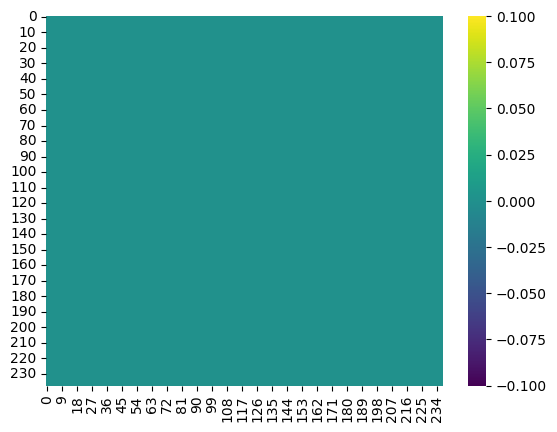

Embedding for'c':


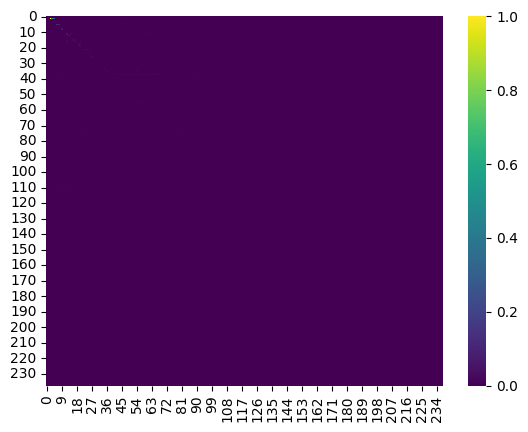

minimum frequency:  10
[[[0.         0.         0.         ... 0.        
{0: 'L', 1: 'c', 2: 'u', 3: '(', 4: '=', 5: 'Y', 6: 'Y:\n', 7: ':', 8: ':\n', 9: ':\n- ', 10: 'T', 11: 'i', 12: 'is ', 13: 'in', 14: 'ing', 15: 'z', 16: 'C', 17: 'k', 18: 'V', 19: 'M', 20: 'w', 21: ' ', 22: ' t', 23: ' th', 24: ' b', 25: ' f', 26: ' s', 27: ' B', 28: ' a', 29: ' g', 30: ' d', 31: ' i', 32: ' h', 33: ' :\n', 34: ')', 35: ')\n', 36: 'U', 37: 'j', 38: 'I', 39: 'e', 40: 'e ', 41: 'er', 42: 'p', 43: ',', 44: ', ', 45: 'd', 46: 'd ', 47: 'da', 48: 'H', 49: '\n', 50: '\nB', 51: '\n- ', 52: '\n(', 53: '\n :\n', 54: '\nA', 55: 'O', 56: '-', 57: '- ', 58: 'B', 59: 'BARRY', 60: 'Barry', 61: ';', 62: 'n', 63: 'ng', 64: 'ng ', 65: 'n ', 66: '.', 67: '.\n', 68: 'A', 69: 'AR', 70: 'ARR', 71: 'h', 72: 'he', 73: 'he ', 74: 'ho', 75: 'hi', 76: '0', 77: 'l', 78: 'll', 79: 'F', 80: 'g', 81: 'g ', 82: '1', 83: 'x', 84: 'J', 85: 't', 86: 'th', 87: 'the', 88: 't ', 89: 's', 90: 's ', 91: 'R', 92: 'RR', 93: 'RY', 94: 'v

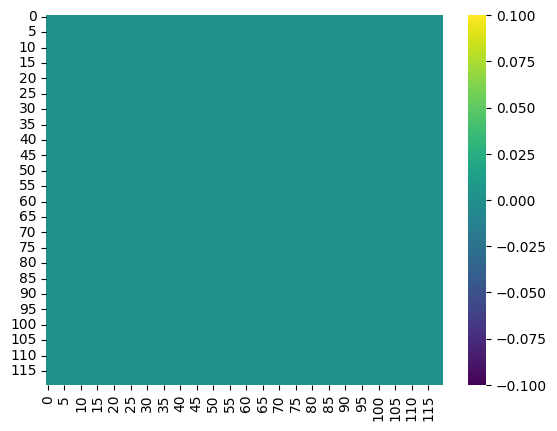

Embedding for'c':


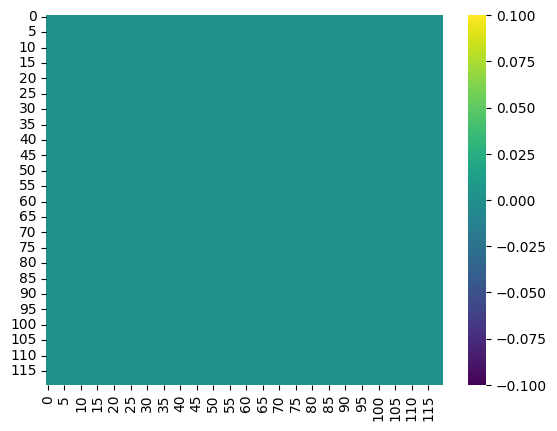

minimum frequency:  15
[[[0.         0.         0.         ... 0.        
{0: 'L', 1: 'c', 2: 'u', 3: '(', 4: '=', 5: 'Y', 6: ':', 7: ':\n', 8: 'T', 9: 'i', 10: 'in', 11: 'z', 12: 'C', 13: 'k', 14: 'V', 15: 'M', 16: 'w', 17: ' ', 18: ' t', 19: ' th', 20: ' b', 21: ' a', 22: ' g', 23: ')', 24: 'U', 25: 'j', 26: 'I', 27: 'e', 28: 'e ', 29: 'p', 30: ',', 31: ', ', 32: 'd', 33: 'd ', 34: 'H', 35: '\n', 36: '\nB', 37: '\n- ', 38: 'O', 39: '-', 40: '- ', 41: 'B', 42: ';', 43: 'n', 44: 'ng', 45: '.', 46: '.\n', 47: 'A', 48: 'AR', 49: 'h', 50: 'he', 51: '0', 52: 'l', 53: 'F', 54: 'g', 55: '1', 56: 'x', 57: 'J', 58: 't', 59: 'th', 60: 't ', 61: 's', 62: 's ', 63: 'R', 64: 'v', 65: 'y', 66: 'y ', 67: '!', 68: 'E', 69: 'N', 70: 'o', 71: 'ou', 72: 'D', 73: 'S', 74: "'", 75: 'b', 76: 'm', 77: 'W', 78: 'f', 79: 'a', 80: 'ar', 81: '?', 82: '8', 83: 'r', 84: 'rry', 85: 'ry', 86: 're'}
Embedding for'L':


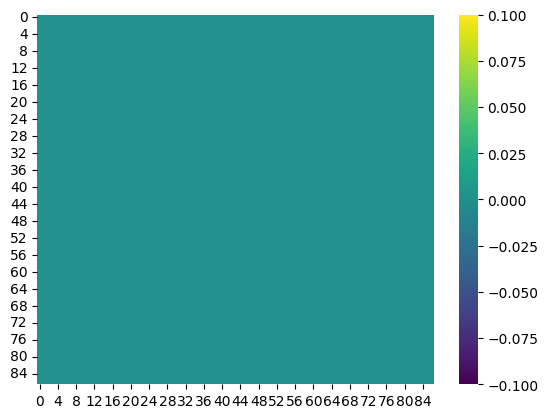

Embedding for'c':


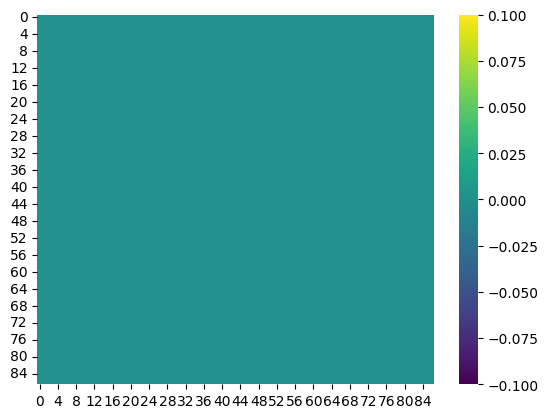

minimum frequency:  20


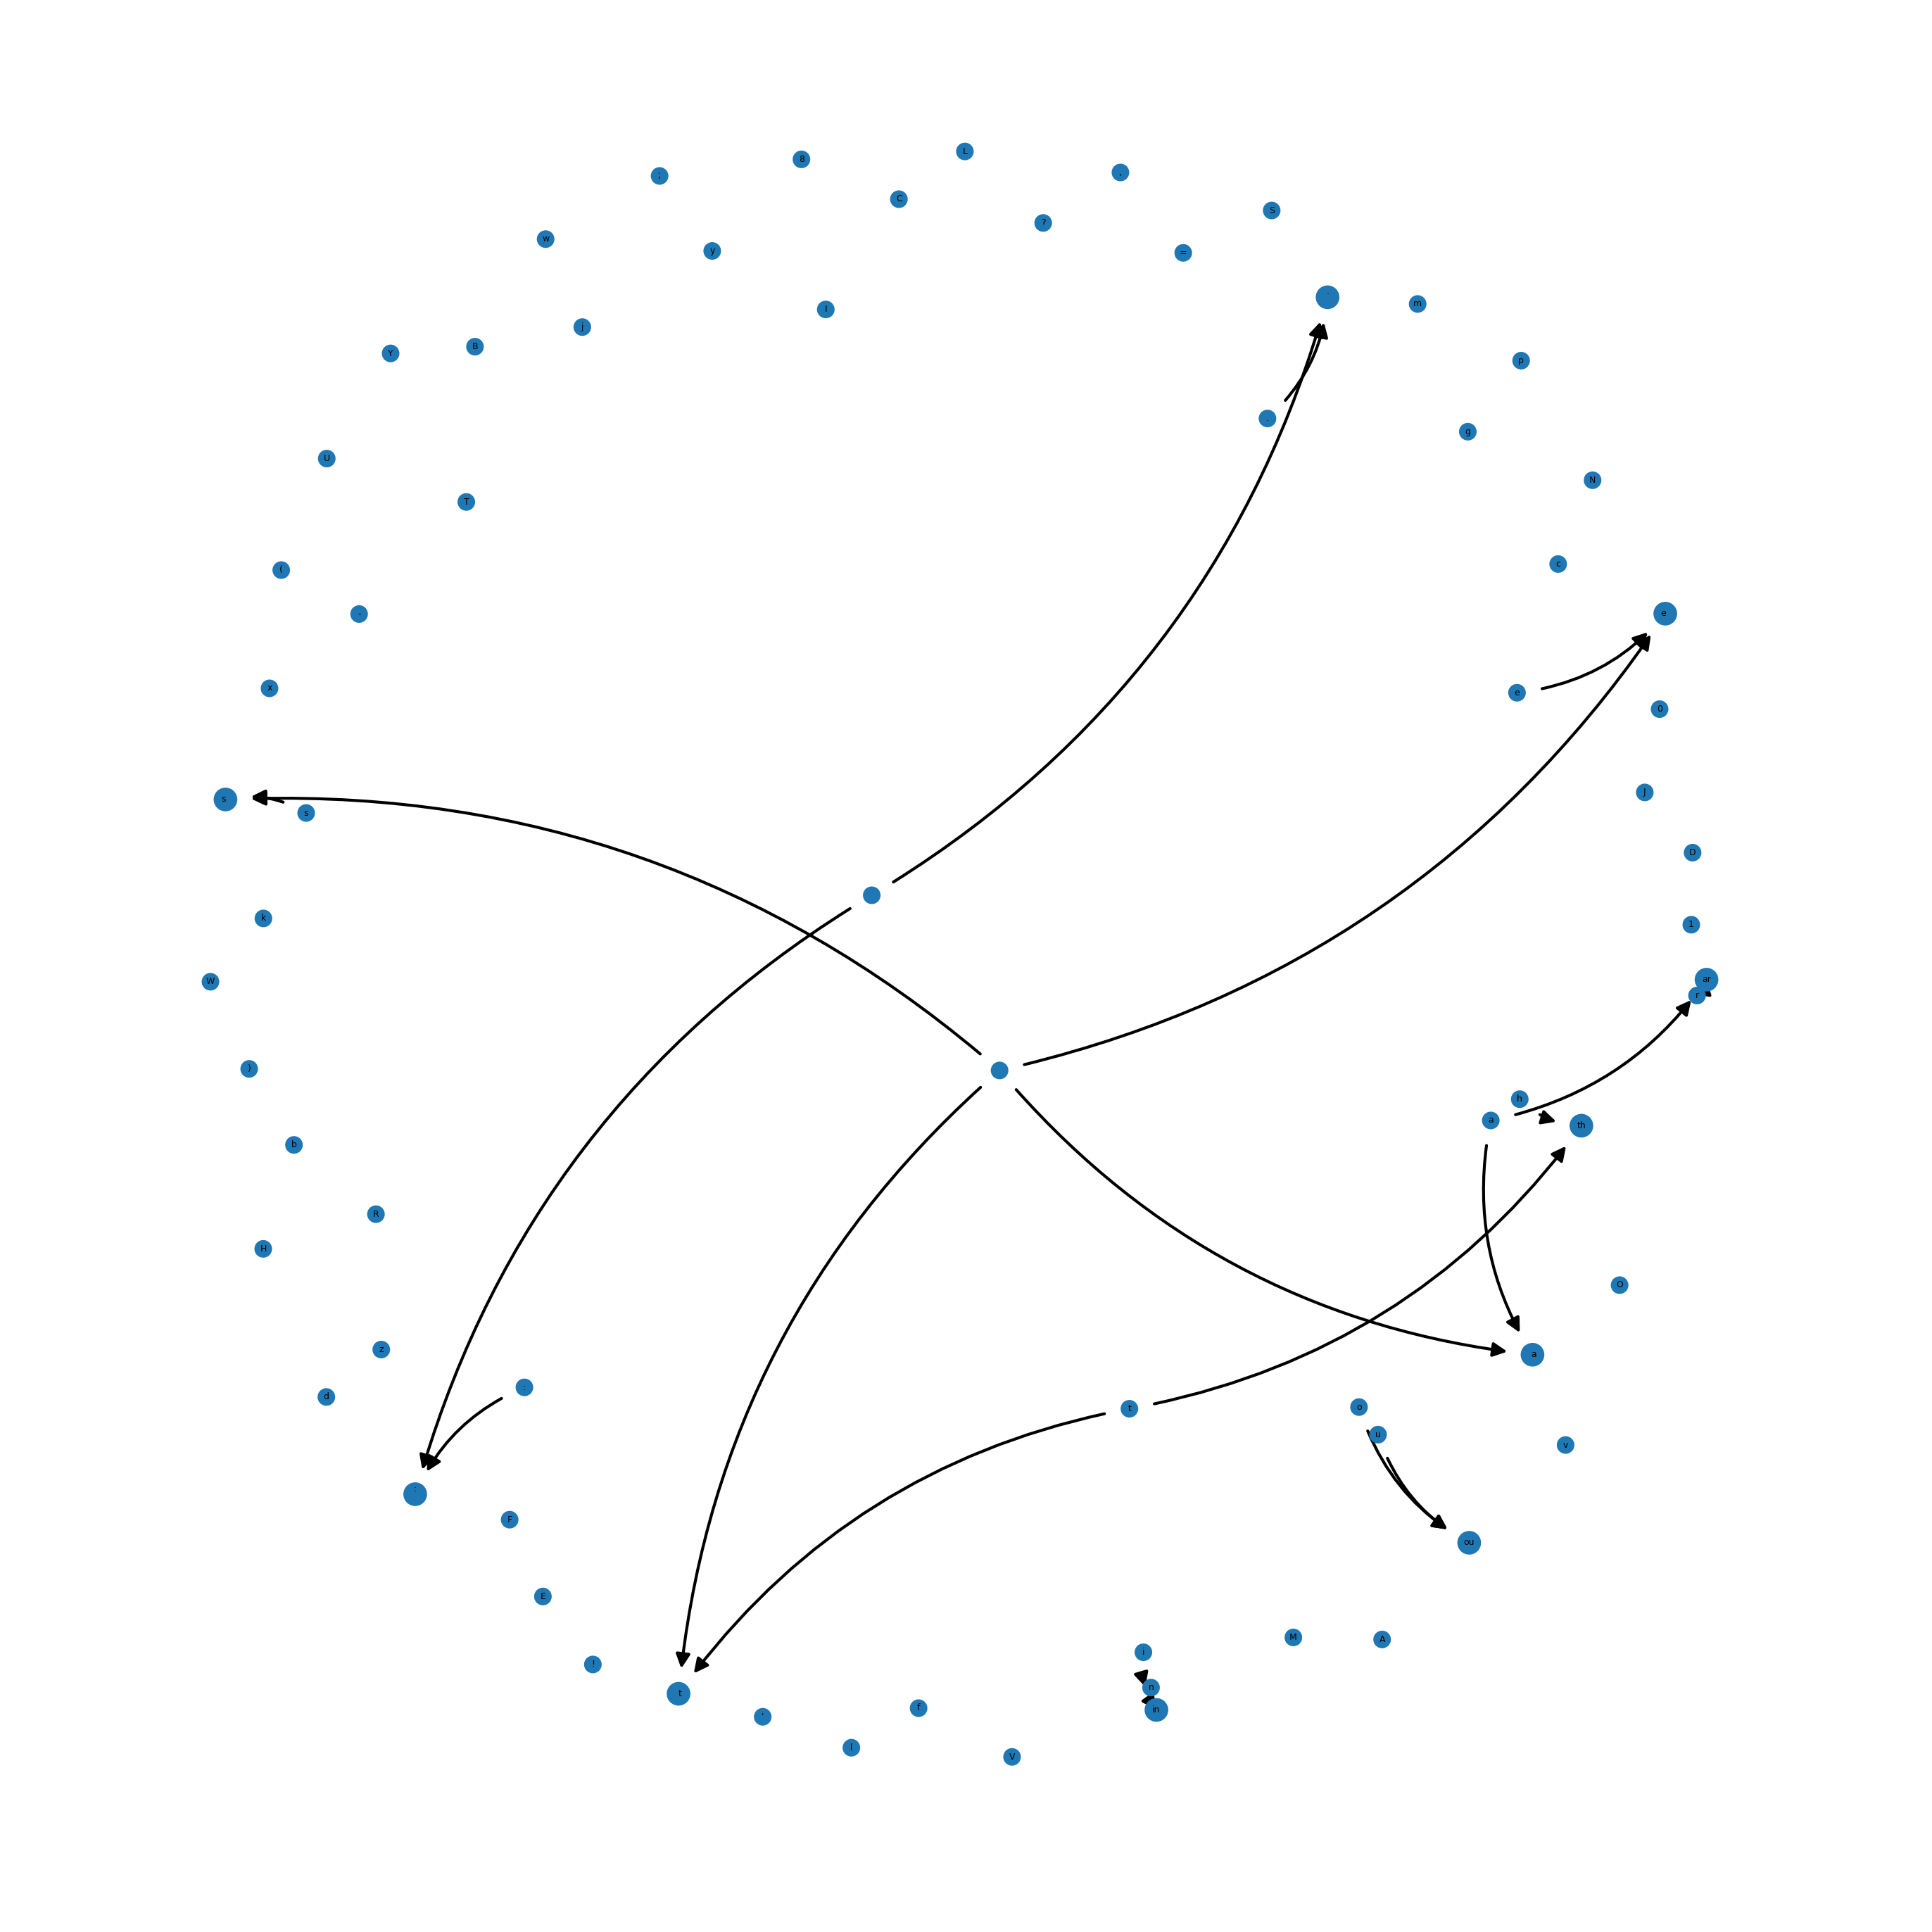

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.
{0: 'L', 1: 'c', 2: 'u', 3: '(', 4: '=', 5: 'Y', 6: ':', 7: ':\n', 8: 'T', 9: 'i', 10: 'in', 11: 'z', 12: 'C', 13: 'k', 14: 'V', 15: 'M', 16: 'w', 17: ' ', 18: ' t', 19: ' a', 20: ')', 21: 'U', 22: 'j', 23: 'I', 24: 'e', 25: 'e ', 26: 'p', 27: ',', 28: 'd', 29: 'H', 30: '\n', 31: 'O', 32: '-', 33: 'B', 34: ';', 35: 'n', 36: '.', 37: '.\n', 38: 'A', 39: 'h', 40: '0', 41: 'l', 42: 'F', 43: 'g', 44: '1', 45: 'x', 46: 'J', 47: 't', 48: 'th', 49: 's', 50: 's ', 51: 'R', 52: 'v', 53: 'y', 54: '!', 55: 'E', 56: 'N', 57: 'o', 58: 'ou', 59: 'D', 60: 'S', 61: "'", 62: 'b', 63: 'm', 64: 'W', 65: 'f', 66: 'a', 67: 'ar', 68: '?', 69: '8', 70: 'r'}
Embedding for'L':


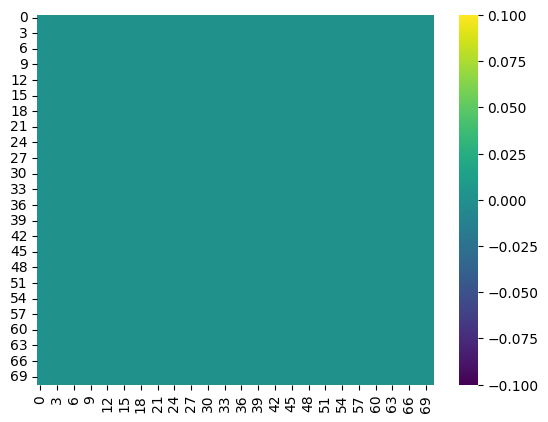

Embedding for'c':


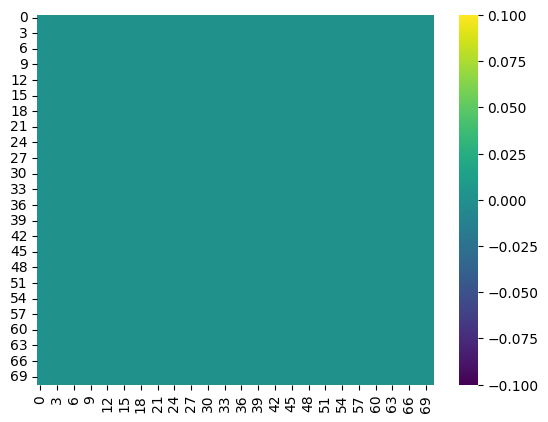


blocking =  True
minimum frequency:  5
[[[0.         1.         0.5        ... 0.        
{0: 'a', 1: 'am', 2: 'at', 3: 'ay', 4: 'ac', 5: 'ar', 6: 'arry', 7: 'arry ', 8: 'an', 9: 'and ', 10: 'ad', 11: 'a ', 12: 'p', 13: 'b', 14: 'bl', 15: 'be', 16: 'L', 17: 'M', 18: 'M:', 19: '-', 20: '- ', 21: 'n', 22: 'n ', 23: 'ng', 24: 'ng ', 25: 'nd', 26: 'nd ', 27: '!', 28: '1', 29: ':', 30: 'd', 31: 'da', 32: 'd ', 33: 'd.', 34: '?', 35: 'C', 36: '0', 37: 'e', 38: 'e,', 39: 'er', 40: 'ee', 41: 'es ', 42: 'ea', 43: 'e.', 44: 'e ', 45: 'e t', 46: 'el', 47: 'ello', 48: ')', 49: 'B', 50: 'BARRY', 51: 'BARRY:', 52: 'Barry', 53: 'Barry ', 54: 'E', 55: 'ET', 56: 'W', 57: 'u', 58: 'us', 59: 'u ', 60: 'y', 61: 'you', 62: 'y ', 63: 'I', 64: "'", 65: "'s", 66: 'r', 67: 'r ', 68: 'ry', 69: 'ry ', 70: 'rry', 71: 'rry ', 72: 'ro', 73: 're', 74: 'i', 75: 'it', 76: 'is ', 77: 'in', 78: 'ing', 79: 'ing ', 80: 'ie', 81: 'w', 82: 'wa', 83: '=', 84: 'F', 85: 'O', 86: 'H', 87: 'He', 88: '8', 89: 'R', 90: 'RY', 91: 

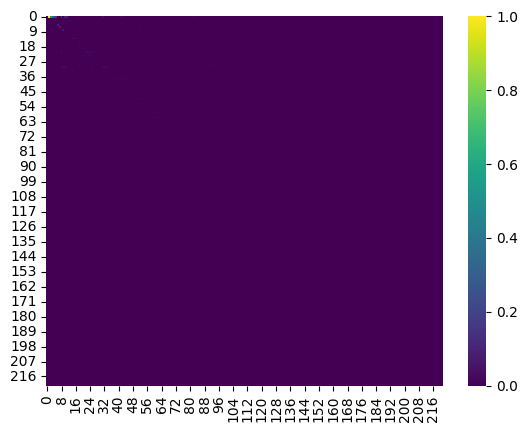

Embedding for'am':


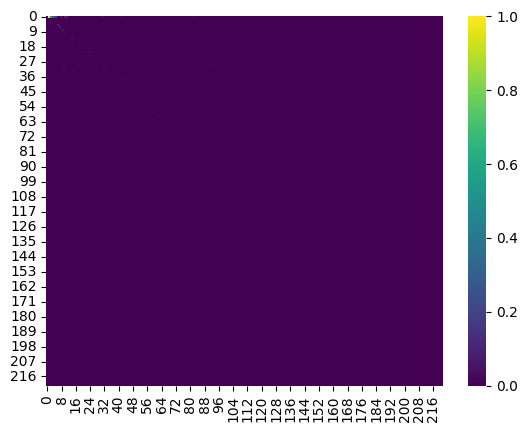

minimum frequency:  10
[[[0.         1.         0.         ... 0.        
{0: 'a', 1: 'ar', 2: 'arry', 3: 'an', 4: 'p', 5: 'b', 6: 'L', 7: 'M', 8: '-', 9: '- ', 10: 'n', 11: 'n ', 12: 'ng', 13: 'ng ', 14: '!', 15: '1', 16: ':', 17: 'd', 18: 'da', 19: 'd ', 20: '?', 21: 'C', 22: '0', 23: 'e', 24: 'er', 25: 'e ', 26: ')', 27: 'B', 28: 'BARRY', 29: 'Barry', 30: 'E', 31: 'W', 32: 'u', 33: 'y', 34: 'y ', 35: 'I', 36: "'", 37: 'r', 38: 'ry', 39: 'rry', 40: 're', 41: 'i', 42: 'is ', 43: 'in', 44: 'ing', 45: 'w', 46: '=', 47: 'F', 48: 'O', 49: 'H', 50: '8', 51: 'R', 52: 'RY', 53: 'RR', 54: 'RRY', 55: 'Y', 56: 'Y:', 57: 'm', 58: 'J', 59: '\n', 60: 'x', 61: 'l', 62: 'll', 63: '(', 64: 'N', 65: 'z', 66: 't', 67: 't ', 68: 'th', 69: 'the', 70: 'U', 71: '.', 72: 'v', 73: 'c', 74: 'D', 75: 'g', 76: 'g ', 77: 'S', 78: 'V', 79: 'o', 80: 'on', 81: 'ou', 82: 'k', 83: 'T', 84: 'j', 85: ' ', 86: ' :', 87: ' s', 88: ' g', 89: ' t', 90: ' th', 91: ' the ', 92: ' B', 93: ' b', 94: ' a', 95: ' f', 96: ' i', 9

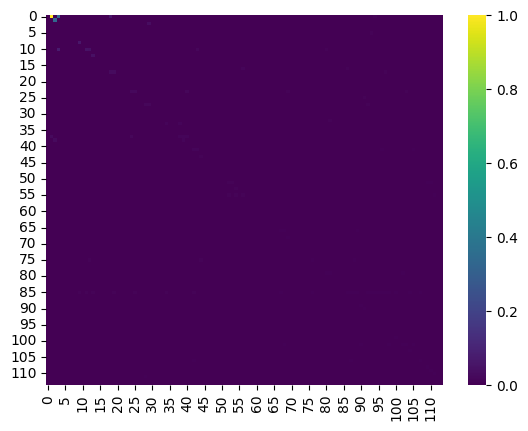

Embedding for'ar':


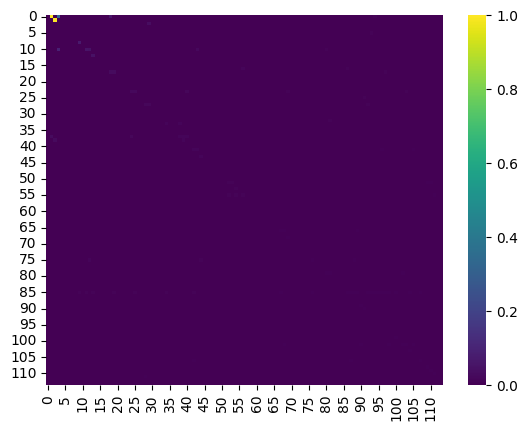

minimum frequency:  15
[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.
{0: 'a', 1: 'ar', 2: 'p', 3: 'b', 4: 'L', 5: 'M', 6: '-', 7: '- ', 8: 'n', 9: 'ng', 10: '!', 11: '1', 12: ':', 13: 'd', 14: 'd ', 15: '?', 16: 'C', 17: '0', 18: 'e', 19: 'e ', 20: ')', 21: 'B', 22: 'E', 23: 'W', 24: 'u', 25: 'y', 26: 'y ', 27: 'I', 28: "'", 29: 'r', 30: 'ry', 31: 'rry', 32: 're', 33: 'i', 34: 'in', 35: 'w', 36: '=', 37: 'F', 38: 'O', 39: 'H', 40: '8', 41: 'R', 42: 'Y', 43: 'm', 44: 'J', 45: '\n', 46: 'x', 47: 'l', 48: '(', 49: 'N', 50: 'z', 51: 't', 52: 't ', 53: 'th', 54: 'U', 55: '.', 56: 'v', 57: 'c', 58: 'D', 59: 'g', 60: 'S', 61: 'V', 62: 'o', 63: 'ou', 64: 'k', 65: 'T', 66: 'j', 67: ' ', 68: ' g', 69: ' t', 70: ' th', 71: ' b', 72: ' a', 73: ',', 74: ', ', 75: 'h', 76: 'he', 77: 's', 78: 's ', 79: 'A', 80: 'AR', 81: ';', 82: 'f'}
Embedding for'a':


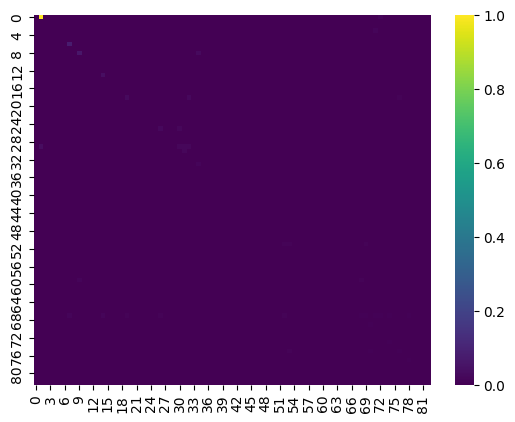

Embedding for'ar':


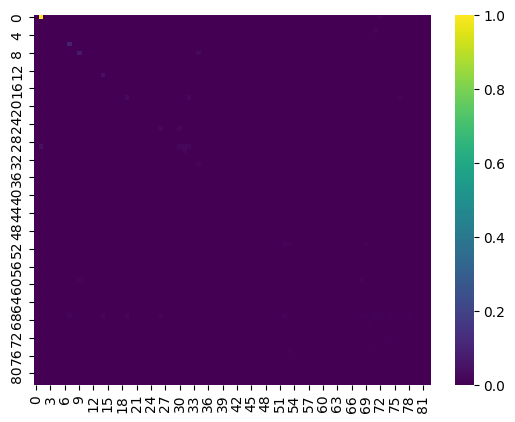

minimum frequency:  20


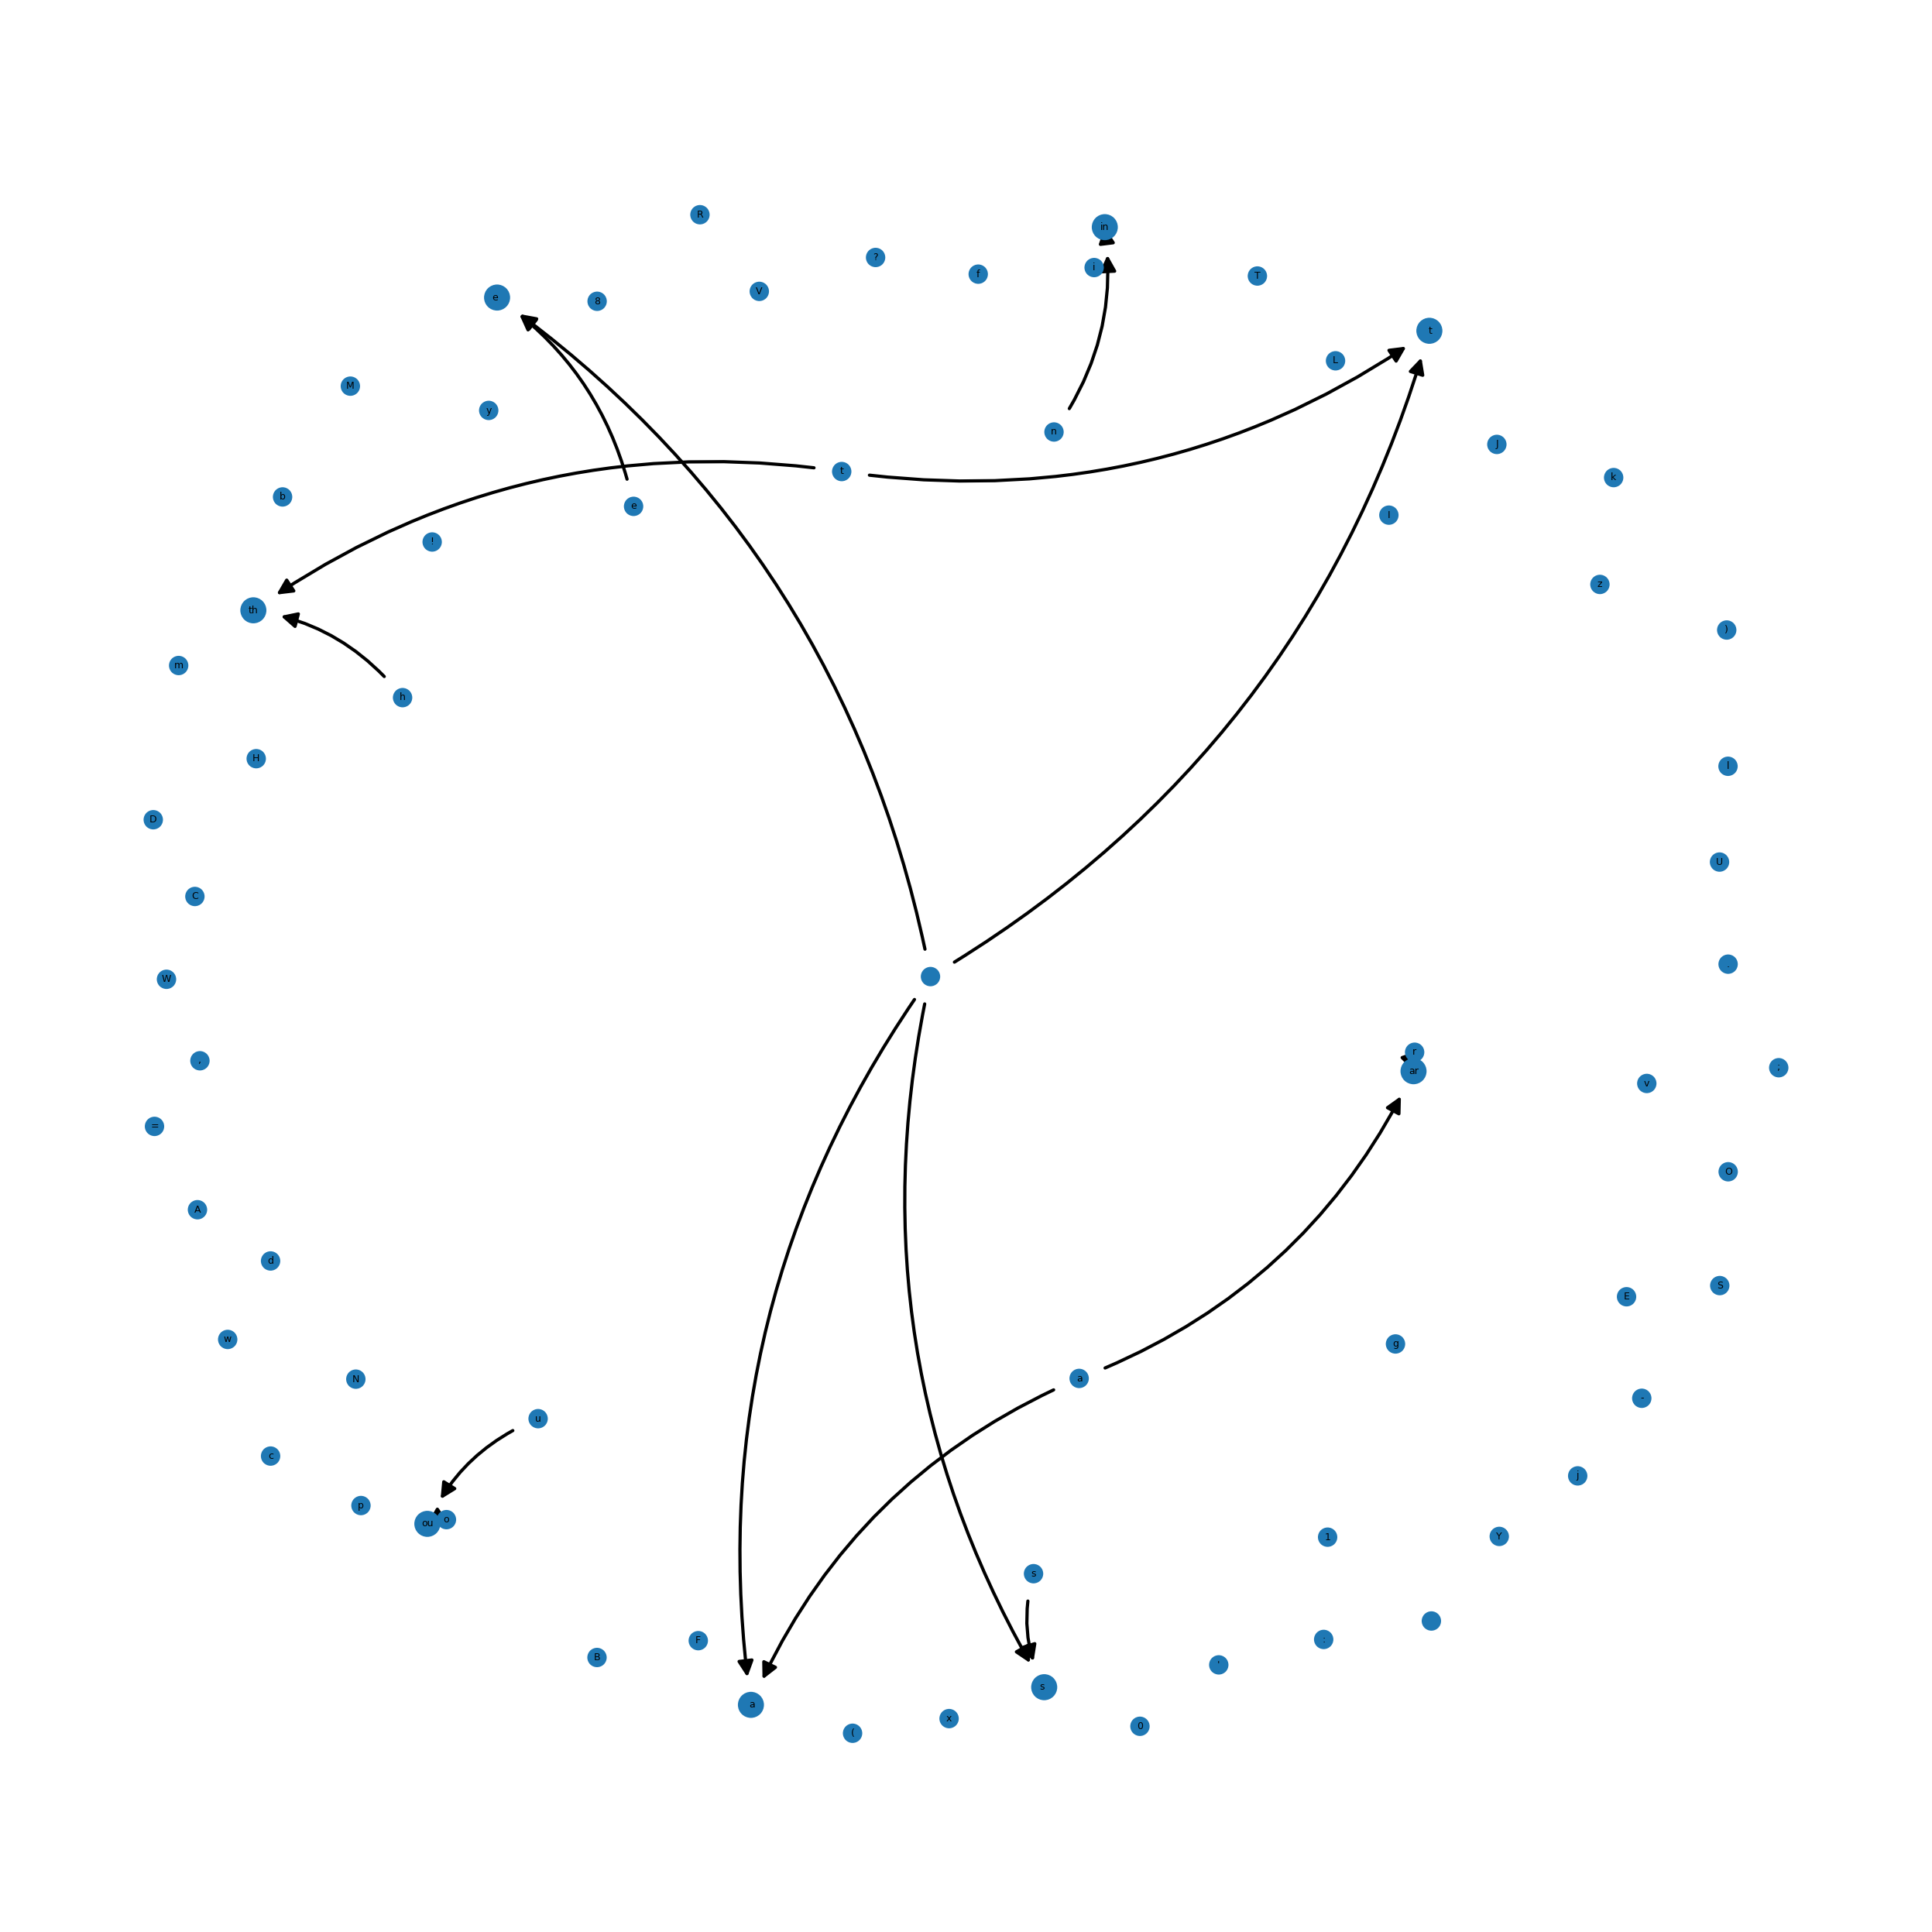

[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.
{0: 'a', 1: 'ar', 2: 'p', 3: 'b', 4: 'L', 5: 'M', 6: '-', 7: 'n', 8: '!', 9: '1', 10: ':', 11: 'd', 12: '?', 13: 'C', 14: '0', 15: 'e', 16: 'e ', 17: ')', 18: 'B', 19: 'E', 20: 'W', 21: 'u', 22: 'y', 23: 'I', 24: "'", 25: 'r', 26: 'i', 27: 'in', 28: 'w', 29: '=', 30: 'F', 31: 'O', 32: 'H', 33: '8', 34: 'R', 35: 'Y', 36: 'm', 37: 'J', 38: '\n', 39: 'x', 40: 'l', 41: '(', 42: 'N', 43: 'z', 44: 't', 45: 'th', 46: 'U', 47: '.', 48: 'v', 49: 'c', 50: 'D', 51: 'g', 52: 'S', 53: 'V', 54: 'o', 55: 'ou', 56: 'k', 57: 'T', 58: 'j', 59: ' ', 60: ' t', 61: ' a', 62: ',', 63: 'h', 64: 's', 65: 's ', 66: 'A', 67: ';', 68: 'f'}
Embedding for'a':


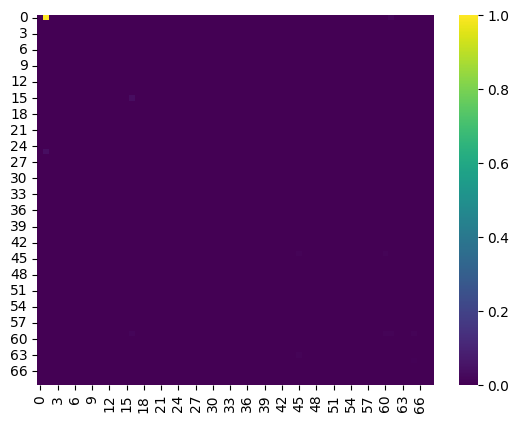

Embedding for'ar':


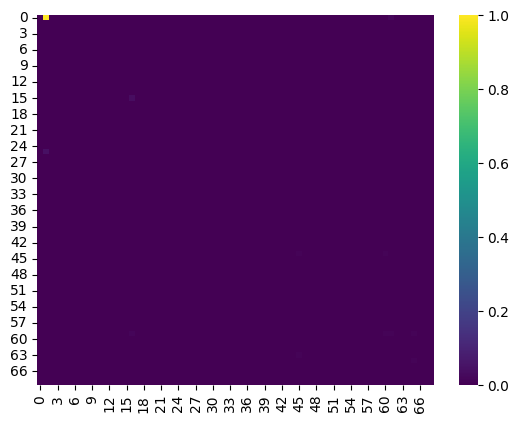

In [84]:
# blocking or non-blocking
for j in range(2):
  print("blocking = ", bool(j))
  prev_trees = dict()

  for min_freq in freq_range:
    print("minimum frequency: ", min_freq)

    for i in range(len(tests)):
      # print("test ", i)
      # if there's no previous tree stored for this test
      if i not in prev_trees.keys():
        prev_trees[i] = None

      mean_times = [0, 0]
      for fold in range(folds):
        new_time=0
        new_time, prev_trees[i], token_vector_mappings = run_test(text=tests[i],
                                                          min_freq=min_freq,
                                                          blocking=bool(j),
                                                          delimeters=r"\n",     #r"\n\n|.\n|\)\n|:|\.\.\.",
                                                          tree=prev_trees[i])
        mean_times[j] += new_time

        plot_embeddings(token_vector_mappings, max_vector_plots)

      test_results["min frequency"].append(min_freq)
      test_results["test number"].append(i)
      test_results["blocking?"].append(j)
      test_results["mean time"].append(mean_times[j]/folds)

  print()

In [33]:
tests_df = pd.DataFrame.from_dict(test_results)
tests_df.head()

,min frequency,test number,blocking?,mean time
0,5,0,0,0.046739
1,10,0,0,0.006101
2,15,0,0,0.003982
3,20,0,0,0.001137
4,5,0,1,0.027976


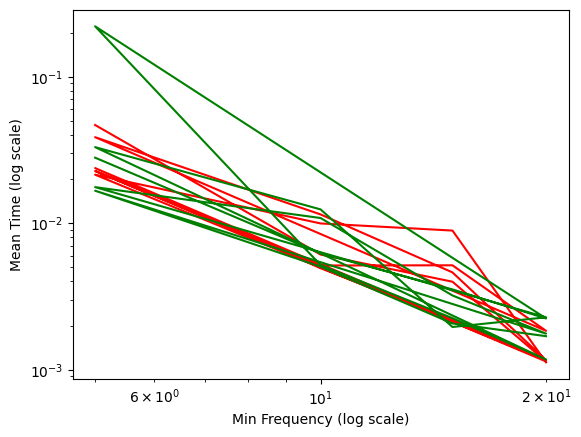

In [34]:
noblock = tests_df[tests_df["blocking?"] == 0]
block = tests_df[tests_df["blocking?"] == 1]
plt.plot(noblock["min frequency"],
          noblock["mean time"],
          "r",
          block["min frequency"],
          block["mean time"],
          "g"
)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Min Frequency (log scale)')
plt.ylabel('Mean Time (log scale)')
plt.show()